In [1]:
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import matplotlib.pyplot as plt
import pytesseract
from easyocr import Reader
import imutils
import cv2
import re
import requests
import numpy as np

In [2]:
# 문서이미지를 보고 확인하기 위한 이미지 조회 함수
def plt_imshow(title='image', img=None, figsize=(16 ,8)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

In [48]:
image_path = '../output/수입면장-FAX-img6.jpg'
org_image = cv2.imread(image_path)
# url = 'https://user-images.githubusercontent.com/69428232/148330274-237d9b23-4a79-4416-8ef1-bb7b2b52edc4.jpg'

# image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
# org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) 

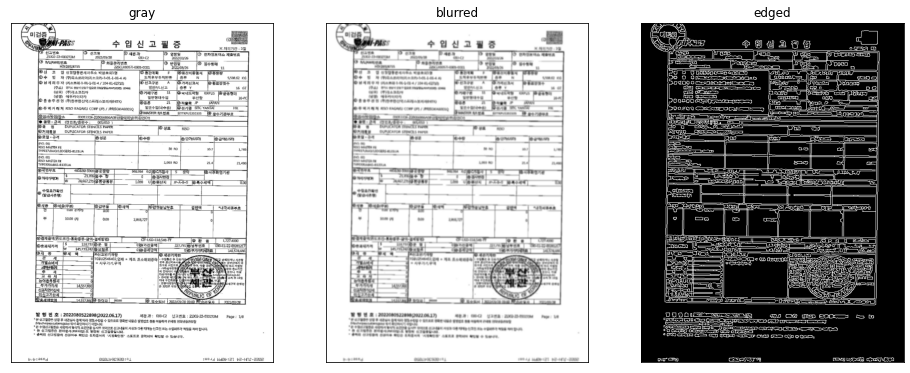

In [49]:
image = org_image.copy()
image = imutils.resize(image, width=500)
ratio = org_image.shape[1] / float(image.shape[1])

# 이미지를 grayscale로 변환하고 blur를 적용
# 모서리를 찾기위한 이미지 연산
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5,), 0)
edged = cv2.Canny(blurred, 75, 200)

plt_imshow(['gray', 'blurred', 'edged'], [gray, blurred, edged])

In [50]:
def crop_image(image, width=420, height=540):
    """
    흰색바탕의 A4크기의 배경에서 수출입신고서 외곽 인식
    Input : image --> 이미지(bgr image)
    return : rot_rect --> 4개의 사각형 좌표와 기운 정도를 나타내는 각도 정보
    """
    crop_success = False
    org_image = image.copy()
    draw_image = image.copy()
    
    image = imutils.resize(image, width=width, height=height)
    ratio = org_image.shape[1] / float(image.shape[1])
    
    ## (1) 이미지 이진화, 흰색부분을 검은색으로 면허증 부분은 흰색으로
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary = cv2.bitwise_not(gray)
    th, threshed = cv2.threshold(binary, 10, 255, cv2.THRESH_BINARY)

    ## (2) Find the max-area contour
    (contours,_) = cv2.findContours(threshed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 면적이 큰거 5개만 추출
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:2]

    screenCnt = None
    for index,c in enumerate(contours):
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            print("contour index==", index)
            screenCnt = approx
            ## This will extract the rotated rect from the contour
            rot_rect = cv2.minAreaRect(screenCnt)
            x, y, w, h = cv2.boundingRect(screenCnt)
            break

    if screenCnt is None:
        print("Do not find rectangle contour")
        crop_img = org_image
    else:
        # show the contour (outline) of the piece of paper
        # print ("Find rectangle contour",rot_rect)
        # print ("x, y, w, h ",x, y, w, h )
        # print ("screenCnt ",screenCnt )
        cv2.drawContours(draw_image, [screenCnt], -1, (0, 255, 0), 2)
        
        # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
        crop_img = four_point_transform(org_image, screenCnt.reshape(4, 2) * ratio)
#         crop_img = image_bgr[y:y + h, x:x + w]
        crop_success = True

    return crop_success, crop_img


flg, crop_image = crop_image(image)
# plt_imshow("문서외곽선인식", edge_detection(image))
if flg:
    plt_imshow(['original', 'croped image'], [image, crop_image])

# cv2.imwrite('../output/수출면장-PDF-img24-crop.jpg', crop_image)



Do not find rectangle contour


before boundingBox [[[ 24   0]]

 [[ 37 446]]

 [[375 451]]

 [[380  46]]]
after boundingBox [[[ 37 446]]

 [[375 446]]

 [[375  46]]

 [[ 37  46]]]
receiptCnt x, y, w, h 37 46 339 401


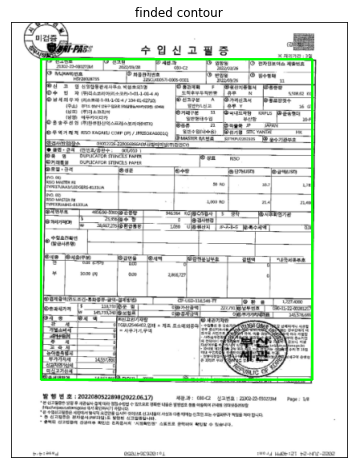

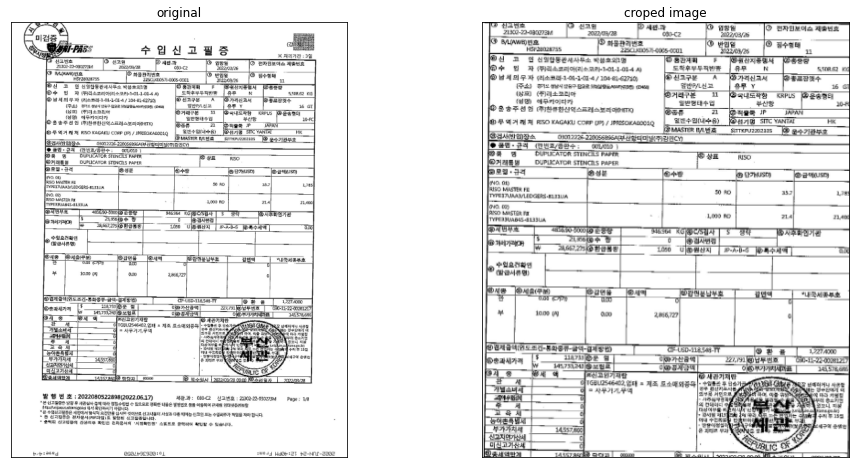

In [52]:
def crop_image1(image, width=420, height=540):
    """
    흰색바탕의 A4크기의 배경에서 수출입신고서 외곽 인식
    Input : image --> 이미지(bgr image)
    return : rot_rect --> 4개의 사각형 좌표와 기운 정도를 나타내는 각도 정보
    """
    crop_success = False
    org_image = image.copy()
    draw_image = image.copy()
    
    image = imutils.resize(image, width=width, height=height)
    ratio = org_image.shape[1] / float(image.shape[1])
    
    ## (1) 이미지 이진화, 흰색부분을 검은색으로 수출입문서 부분은 흰색으로
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary = cv2.bitwise_not(gray)
    th, threshed = cv2.threshold(binary, 10, 255, cv2.THRESH_BINARY)
    ## (2) Find the max-area contour
    # contours를 찾아 크기순으로 정렬
    # cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = cv2.findContours(threshed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(contours)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)


    receiptCnt = None

    # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.1 * peri, True)

        # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영수증 영역으로 판단하고 break
        if len(approx) == 4:
            receiptCnt = approx
            break


    # 만약 추출한 윤곽이 없을 경우 오류
    if receiptCnt is None:
        print("Do not find rectangle contour")
        crop_img = org_image
    else:
        print("before boundingBox",receiptCnt )
#         print("approx[1][0]:",receiptCnt[1][0] )
#         print("approx[2][0]:",receiptCnt[2][0] )
#         print("approx[3][0]:",receiptCnt[3][0] )
#         print("approx[0][0][1]:",receiptCnt[0][0][1] )
        # x1,y1의 좌표를 변형하여 4곡지점 다각형에서 직사각형을 만드는 시도 
        receiptCnt[0][0][0] = receiptCnt[1][0][0]
        receiptCnt[0][0][1] = receiptCnt[1][0][1]
        receiptCnt[1][0][0] = receiptCnt[2][0][0]
        receiptCnt[2][0][1] = receiptCnt[3][0][1]
        receiptCnt[3][0][0] = receiptCnt[0][0][0]
        print("after boundingBox",receiptCnt )

        x, y, w, h = cv2.boundingRect(receiptCnt)
        print("receiptCnt x, y, w, h",x, y, w, h )
        # x, y값을 보정하여 정사각형으로 변환 [y+44:y+h, x+21:x+w]
        draw_image = image.copy()
        cv2.drawContours(draw_image, [receiptCnt], -1, (0, 255, 0), 2)
        plt_imshow('finded contour', draw_image)
        # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
        crop_img = four_point_transform(org_image, receiptCnt.reshape(4, 2) * ratio)
        # crop_img = image_bgr[y+44:y+h, x+21:x+w]
        crop_success = True


    return crop_success, crop_img


flg, crop_image = crop_image1(image)
# plt_imshow("문서외곽선인식", edge_detection(image))
if flg:
    plt_imshow(['original', 'croped image'], [image, crop_image])